In [399]:
import regex
import tarfile

from matplotlib import pyplot as plt

In [384]:
def read_archive(path):
    tar = tarfile.open(path, "r:gz")   
    files = {}
    for filename in tar.getnames():
        f = tar.extractfile(filename)
        files[filename] = f.read().decode("utf-8").replace('\n', ' ').replace('\t', ' ')
    return files

In [385]:
def find_matches(regexes, flections):
    matches=[sum(
            [len(
                regex.findall(r, f, flags=regex.IGNORECASE))
             for k,f in files.items()])
        for r in regexes]
    return dict(zip(flections,matches))

# Zadanie 1

In [422]:
# source: 
# ROZPORZĄDZENIE
# PREZESA RADY MINISTRÓW/
# z dnia 20 czerwca 2002 r.
# w sprawie "Zasad techniki prawodawczej" §85

#https://sip.lex.pl/akty-prawne/dzu-dziennik-ustaw/zasady-techniki-prawodawczej-16968290
additions=r'po art\.\s\d+ dodaje\ssię\sart'
removals=r'uchyla\ssię\sart'
removals2=r'.{40}skreśla\ssię.{40}'

files = read_archive('ustawy.tar.gz')


[regex.findall(removals2, f, flags=regex.IGNORECASE) for k,f in files.items()]

[['16";       5) w art. 9:     a) w ust. 1 skreśla się wyrazy "nie później niż na 30 dni",    ',
  'ącu następnym.",     c) w ust. 4 kropkę skreśla się i dodaje wyrazy "nie później jednak niż',
  '           zwrot różnicy podatku."; 12) skreśla się art. 22; 13) art. 23 otrzymuje brzmieni',
  'półek prawa handlowego."; 15) w art. 26 skreśla się:     a) oznaczenie ust. 1 oraz wyrazy "',
  'ia.";            17) w art. 29 w ust. 4 skreśla się wyrazy "w porozumieniu z Prezesem Polsk',
  ') w ust. 2 po wyrazach "wykazy towarów" skreśla się wyrazy "i usług",     b) dodaje się ust'],
 ['e zmiany:  1) w art. 7 w ust. 5 w pkt 4 skreśla się wyrazy "przeciętnego wynagrodzenia";   ',
  '           4) w art. 17:    a) w ust. 1 skreśla się wyrazy "zwany dalej wskaźnikiem waloryz'],
 [' poz. 133 i Nr 129, poz. 602) w art. 27 skreśla się wyrazy "jednak nie dłużej niż do dnia 3'],
 ['obliczonego od połowy dochodów.",    b) skreśla się ust. 6,    c) w ust. 7 kropkę zastępuje',
  '    - w pkt 1 po wyrazac

# Zadanie 4

In [386]:
#got from https://sjp.pl/ustawa
flections=['ustawa', 'ustawą', 'ustawę', 'ustawie', 'ustawo', 'ustawy', 'ustawach', 'ustawami', 'ustawom', 'ustaw']

In [387]:
r = r'\b('+r' | '.join(flections)+ r')\b'
regexes=[r'\b'+f +r'\b' for f in flections]

In [388]:
r

'\\b(ustawa | ustawą | ustawę | ustawie | ustawo | ustawy | ustawach | ustawami | ustawom | ustaw)\\b'

In [389]:
files = read_archive('ustawy.tar.gz')
matches4=find_matches(regexes, flections)

In [390]:
matches4

{'ustawa': 3235,
 'ustawą': 1118,
 'ustawę': 829,
 'ustawie': 5478,
 'ustawo': 0,
 'ustawy': 13099,
 'ustawach': 178,
 'ustawami': 76,
 'ustawom': 12,
 'ustaw': 909}

## Edge case: ustaw as verb

In [345]:
scopes=[regex.findall(r'.{10}\bustaw\b.{10}', f, flags=regex.IGNORECASE)for k,f in files.items()]

result=[]
for s in scopes:
    if len(s) > 0:
        result += s
        
set(result)

{'          Ustaw Rzeczypos',
 '          ustaw          ',
 '          ustaw dotyczące',
 '          ustaw i rozporz',
 '          ustaw i ustawę ',
 '          ustaw lub przep',
 '          ustaw podatkowy',
 '          ustaw regulując',
 '          ustaw,         ',
 '          ustaw, biuro no',
 '          ustaw, umów lub',
 '     albo ustaw nie można',
 '    zmian ustaw  konstytu',
 '   innych ustaw          ',
 '   innych ustaw (Dz.U. Nr',
 '   innych ustaw i aktów w',
 '   innych ustaw należy do',
 '   innych ustaw.",    b) ',
 '  a także ustaw o zmianie',
 '  zmianie ustaw Kodeks cy',
 ' Dziennik Ustaw Rzeczypos',
 ' Dziennik Ustaw i Monitor',
 ' Dziennik Ustaw, Monitor ',
 ' Przepisy ustaw zmieniany',
 ' Przepisy ustaw, o któryc',
 ' i innych ustaw          ',
 ' i innych ustaw będę ściś',
 ' i innych ustaw oraz     ',
 ' i innych ustaw,         ',
 ' naruszeń ustaw dopuści  ',
 ' projekty ustaw, rozporzą',
 ' przepisy ustaw      odrę',
 ' przepisy ustaw   szczegó',
 ' przepis

not found


# Zadanie 5

In [346]:
regexes5 = [r+r' (?=\sz dnia)' for r in regexes]

In [347]:
regexes5

['\\bustawa\\b (?=\\sz dnia)',
 '\\bustawą\\b (?=\\sz dnia)',
 '\\bustawę\\b (?=\\sz dnia)',
 '\\bustawie\\b (?=\\sz dnia)',
 '\\bustawo\\b (?=\\sz dnia)',
 '\\bustawy\\b (?=\\sz dnia)',
 '\\bustawach\\b (?=\\sz dnia)',
 '\\bustawami\\b (?=\\sz dnia)',
 '\\bustawom\\b (?=\\sz dnia)',
 '\\bustaw\\b (?=\\sz dnia)']

In [391]:
files = read_archive('ustawy.tar.gz')
matches5=find_matches(regexes5, flections)

In [392]:
matches5

{'ustawa': 9,
 'ustawą': 0,
 'ustawę': 2,
 'ustawie': 10,
 'ustawo': 0,
 'ustawy': 10,
 'ustawach': 0,
 'ustawami': 0,
 'ustawom': 0,
 'ustaw': 0}

# Zadanie 6

In [350]:
regexes6 = [r+r'(?!\sz dnia)' for r in regexes]

In [351]:
regexes6

['\\bustawa\\b(?!\\sz dnia)',
 '\\bustawą\\b(?!\\sz dnia)',
 '\\bustawę\\b(?!\\sz dnia)',
 '\\bustawie\\b(?!\\sz dnia)',
 '\\bustawo\\b(?!\\sz dnia)',
 '\\bustawy\\b(?!\\sz dnia)',
 '\\bustawach\\b(?!\\sz dnia)',
 '\\bustawami\\b(?!\\sz dnia)',
 '\\bustawom\\b(?!\\sz dnia)',
 '\\bustaw\\b(?!\\sz dnia)']

In [393]:
files = read_archive('ustawy.tar.gz')
matches6=find_matches(regexes6, flections)

In [394]:
matches6

{'ustawa': 366,
 'ustawą': 55,
 'ustawę': 588,
 'ustawie': 3591,
 'ustawo': 0,
 'ustawy': 2819,
 'ustawach': 1,
 'ustawami': 0,
 'ustawom': 0,
 'ustaw': 0}

In [395]:
for k, v in matches4.items():
    print(k, v, matches5[k], matches6[k])
    
   # assert(matches5[k]+matches6[k]==v)

ustawa 3235 9 366
ustawą 1118 0 55
ustawę 829 2 588
ustawie 5478 10 3591
ustawo 0 0 0
ustawy 13099 10 2819
ustawach 178 0 1
ustawami 76 0 0
ustawom 12 0 0
ustaw 909 0 0


# Zadanie 7

In [380]:
regexes7 = [r'(?<!\bo\szmianie\b\s)'+r for r in regexes]

In [381]:
regexes7

['(?<!\\bo\\szmianie\\b\\s)\\bustawa\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawą\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawę\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawie\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawo\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawy\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawach\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawami\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustawom\\b',
 '(?<!\\bo\\szmianie\\b\\s)\\bustaw\\b']

In [396]:
files = read_archive('ustawy.tar.gz')
matches7=find_matches(regexes7, flections)

In [397]:
matches7

{'ustawa': 3235,
 'ustawą': 1118,
 'ustawę': 829,
 'ustawie': 5478,
 'ustawo': 0,
 'ustawy': 12263,
 'ustawach': 178,
 'ustawami': 76,
 'ustawom': 12,
 'ustaw': 893}

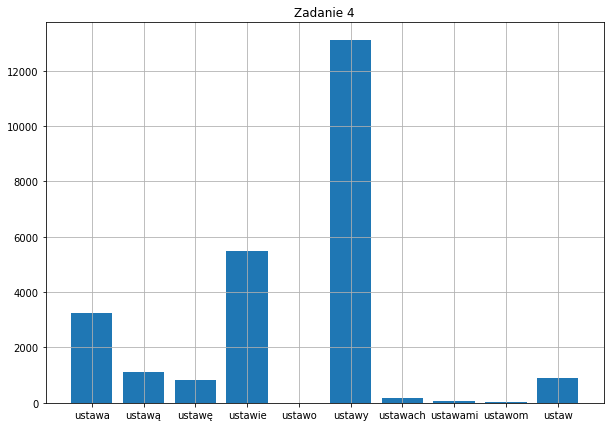

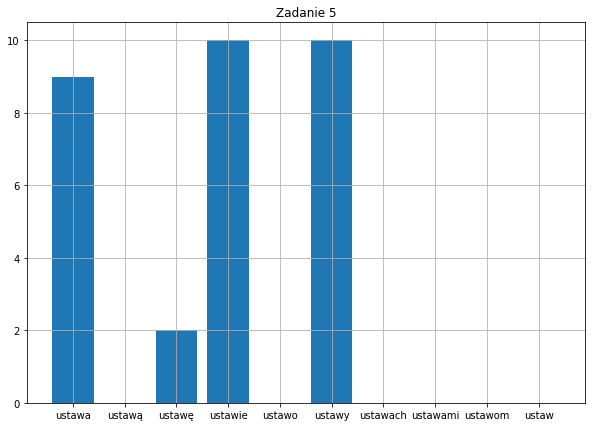

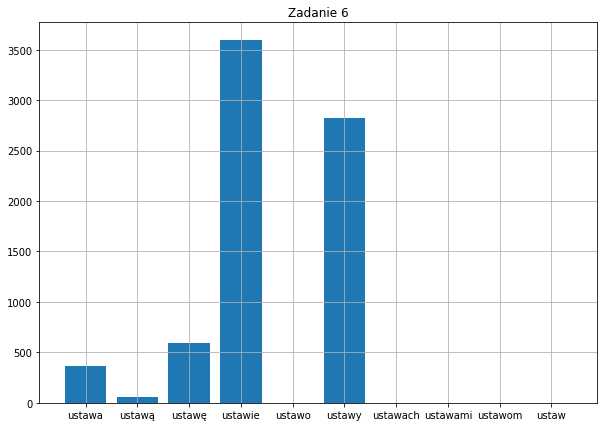

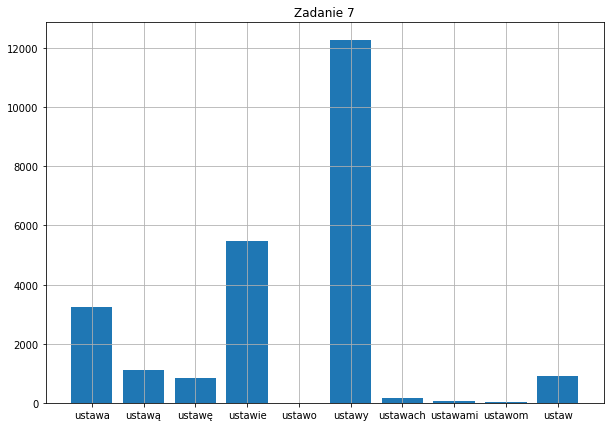

In [414]:
i=4
for m in [matches4, matches5, matches6, matches7]:
    plt.figure(figsize=(10, 7))
    plt.grid()
    plt.title(f"Zadanie {i}")
    plt.bar(m.keys(), m.values(), label=m.keys())
    plt.show()
    i+=1